#NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


## RECAP on filter maps in CNNs

How do channels change from input_channels to output_channels? Let's assume we have RGB image (input_channels = 3 channels) and the output_channels = 1. The result of the 3 kernel_maps are summed:

https://i.stack.imgur.com/CQtHP.gif

If you have output_channels = n and kernel_size=(3,3), you are creating n different filters, each of them with shape (3,3,3). The result will bring 32 different convolutions. Filters are randomly initialized at the beginning.



## Lab. 06 - Transfer Learning

In this lab. we will start from a network wich has already been trained, trying to transfer some of the knowledge previously gained to a similar but more specific task. 

In particular, the netowork has been originally trained to solve a multi-class classification problem over 1,000 different categories. We will try to specialize the network on just 4 targeted classes, taking training data from a different dataset.

ORIGINAL NETWORK

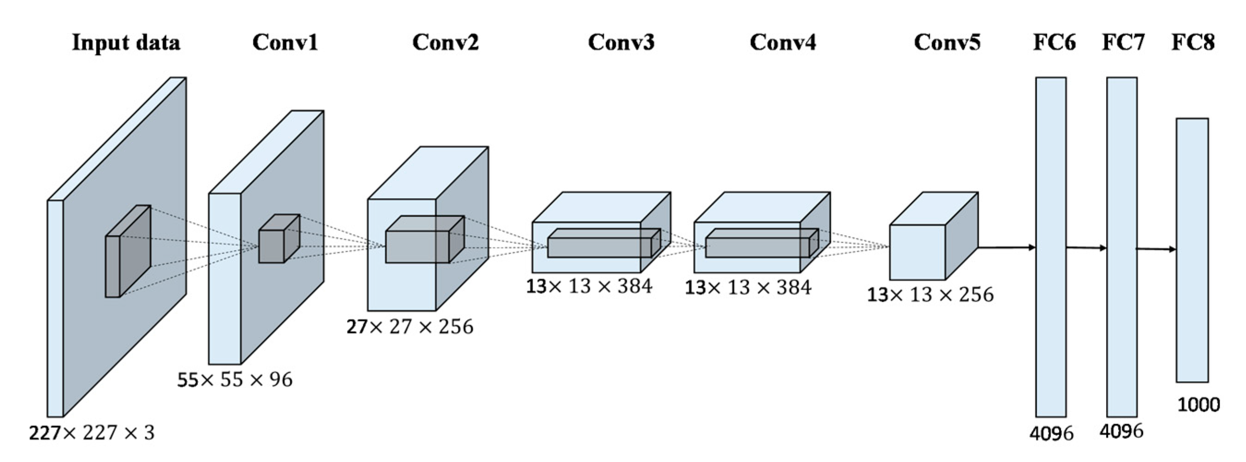

MODIFIED ARCHITECTURE

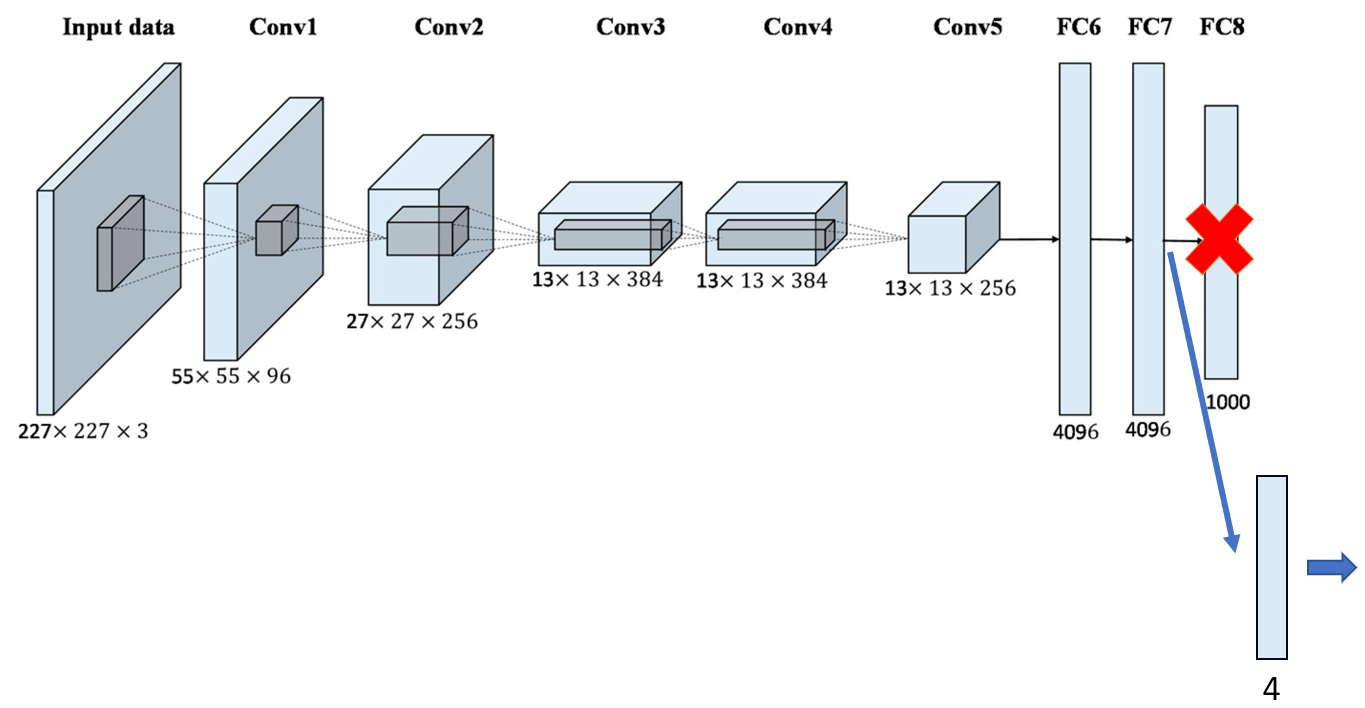

In [1]:
#!pip install plotly.express

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px # this is another plotting library for interactive plot

from sklearn.model_selection import train_test_split
from sklearn import metrics, manifold # we will use the metrics and manifold learning modules from scikit-learn
from pathlib import Path # to interact with file paths
from PIL import Image # to interact with images
from tqdm import tqdm # progress bar
from pprint import pprint # pretty print (useful for a more readable print of objects like lists or dictionaries)

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Dataset

## Data download 

This cell download a txt file "imagenet1000_clsid_to_human.txt" containing the class name of the pretrained network. Take a look on the file in the local *Files* section.

In [2]:
!wget https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/imagenet1000_clsid_to_human.txt

--2021-12-08 10:54:43--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/imagenet1000_clsid_to_human.txt
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsid_to_human.txt.6’

imagenet1000_clsid_ 100%[===================>]  29,85K  --.-KB/s    in 0,04s   

2021-12-08 10:54:43 (667 KB/s) - ‘imagenet1000_clsid_to_human.txt.6’ saved [30564/30564]



This cell installs the library [*openimages*](https://github.com/monocongo/openimages) in the Colab environment through the pip package repository. This is just a utiliy library that will be used only to download the train and test images.

In [3]:
# uncomment if it's the first time you run the notebook
#!pip install openimages

Let's donwnload some images from the openimage dataset (https://storage.googleapis.com/openimages/web/index.html).

This cell downloads images of the specified classes, and saves them in the `dest_dir` local folder.

In [4]:
from openimages.download import download_images
images_location = download_images(
    dest_dir='dataset',
    class_labels=['Muffin', 'Aircraft', 'Apple', 'Cat'],
    exclusions_path=None,
    csv_dir=None,
    limit=1000,
)

2021-12-08  10:58:46 INFO Downloading 552 train images for class 'muffin'
100%|██████████| 552/552 [00:34<00:00, 15.83it/s]
2021-12-08  10:59:21 INFO Downloading 473 train images for class 'aircraft'
100%|██████████| 473/473 [00:26<00:00, 17.55it/s]
2021-12-08  10:59:48 INFO Downloading 312 train images for class 'apple'
100%|██████████| 312/312 [00:18<00:00, 16.86it/s]
2021-12-08  11:00:07 INFO Downloading 1000 train images for class 'cat'
100%|██████████| 1000/1000 [01:03<00:00, 15.80it/s]
2021-12-08  11:01:14 INFO Downloading 19 validation images for class 'muffin'
100%|██████████| 19/19 [00:06<00:00,  3.08it/s]
2021-12-08  11:01:20 INFO Downloading 62 validation images for class 'aircraft'
100%|██████████| 62/62 [00:04<00:00, 13.00it/s]
2021-12-08  11:01:25 INFO Downloading 23 validation images for class 'apple'
100%|██████████| 23/23 [00:06<00:00,  3.65it/s]
2021-12-08  11:01:43 INFO Downloading 55 test images for class 'muffin'
100%|██████████| 55/55 [00:04<00:00, 12.99it/s]
2021

The ouput of the previous function is a dictionary where the keys represent the class names and the values are the locations of the just downloaded images.

This will be useful to create our dataset.

In [5]:
pprint(images_location)

{'aircraft': 'dataset/aircraft/images',
 'apple': 'dataset/apple/images',
 'cat': 'dataset/cat/images',
 'muffin': 'dataset/muffin/images'}


Finally, we need to associate each class to an id:

In [6]:
# Dictionary containing the mapping from label name to ID
label_to_id = {
  'aircraft': 0,
  'apple': 1,
  'cat': 2,
  'muffin': 3
}
# Dictionary containing the mapping from ID to label name
id_to_label = {id: label for label, id in label_to_id.items()}

print('label_to_id =', label_to_id)
print('id_to_label =', id_to_label)

label_to_id = {'aircraft': 0, 'apple': 1, 'cat': 2, 'muffin': 3}
id_to_label = {0: 'aircraft', 1: 'apple', 2: 'cat', 3: 'muffin'}


## Train/Test split

First of all, let's create a list containing all the available samples. Each element of the list is a tuple where the first element is the path of the image, and the second element is the corresponding class name.

For convenience, we are using the python `pathlib` library (https://docs.python.org/3/library/pathlib.html) to interact with local filepaths, in particular the `Path` class. This allows to write OS independent code, and it also has very practical utility methods.

In [7]:
# List all images
all_samples = [] # Initialize the list
for label_name, dir in images_location.items(): # Iterate through the location of the downloaded images folders (the dictionary returned by the download_images function above)
  label = label_to_id[label_name] # Convert the label name to the label ID
  for filepath in Path(dir).iterdir(): # Iterate through the files inside the directory (.iterdir)
    all_samples.append((filepath, label)) # Append the filepath and the label to the list
all_samples.sort() # Sort the list (to be sure that the order of the samples is always the same for the following train/test split)

pprint(all_samples[:10]) # pprint stands for "pretty print", this is just for a more readable print of some objects

[(PosixPath('dataset/aircraft/images/00144844bdaf8351.jpg'), 0),
 (PosixPath('dataset/aircraft/images/0021ea873f2e416e.jpg'), 0),
 (PosixPath('dataset/aircraft/images/0023b0e23b369b8d.jpg'), 0),
 (PosixPath('dataset/aircraft/images/002ff6e1eecb80b8.jpg'), 0),
 (PosixPath('dataset/aircraft/images/003b2d3c807da35f.jpg'), 0),
 (PosixPath('dataset/aircraft/images/0057f6a4bf6997a9.jpg'), 0),
 (PosixPath('dataset/aircraft/images/006130a7fc2e99cc.jpg'), 0),
 (PosixPath('dataset/aircraft/images/008b0ea15dfca327.jpg'), 0),
 (PosixPath('dataset/aircraft/images/00ef6583b9a09e4e.jpg'), 0),
 (PosixPath('dataset/aircraft/images/00f7f375379ee063.jpg'), 0)]


Now we first keep a 20% of data for testing. The remaining 80% of data is further divided in train and validation.

The `stratify` parameter ensures that the fraction of data for each class will be as equal as possibile among the splits.


In [8]:
# Create the test set (20%)
train_samples, test_samples = train_test_split(all_samples, test_size=0.2, stratify=[s[1] for s in all_samples], shuffle=True, random_state=0)
# Create the train (80%) and validation set (20%) from the remaining data
train_samples, val_samples = train_test_split(train_samples, test_size=0.2, stratify=[s[1] for s in train_samples], shuffle=True, random_state=0)

print("--- TRAIN SAMPLES ---")
print(pd.DataFrame(train_samples)[1].value_counts()) # The "value_counts()" method of pandas DataFrame allows easily count the number of samples for each class
print("\n--- TRAIN SAMPLES (PERCENTAGE) ---")
print(pd.DataFrame(train_samples)[1].value_counts() / len(train_samples) * 100) 

print("\n--- VALIDATION SAMPLES ---")
print(pd.DataFrame(val_samples)[1].value_counts())
print("\n--- VALIDATION SAMPLES (PERCENTAGE) ---")
print(pd.DataFrame(val_samples)[1].value_counts() / len(val_samples) * 100) 

print("\n--- TEST SAMPLES ---")
print(pd.DataFrame(test_samples)[1].value_counts())
print("\n--- TEST SAMPLES (PERCENTAGE) ---")
print(pd.DataFrame(test_samples)[1].value_counts() / len(test_samples) * 100) 

--- TRAIN SAMPLES ---
2    640
0    456
3    401
1    249
Name: 1, dtype: int64

--- TRAIN SAMPLES (PERCENTAGE) ---
2    36.655212
0    26.116838
3    22.966781
1    14.261168
Name: 1, dtype: float64

--- VALIDATION SAMPLES ---
2    160
0    115
3    100
1     62
Name: 1, dtype: int64

--- VALIDATION SAMPLES (PERCENTAGE) ---
2    36.613272
0    26.315789
3    22.883295
1    14.187643
Name: 1, dtype: float64

--- TEST SAMPLES ---
2    200
0    143
3    125
1     78
Name: 1, dtype: int64

--- TEST SAMPLES (PERCENTAGE) ---
2    36.630037
0    26.190476
3    22.893773
1    14.285714
Name: 1, dtype: float64


## Dataset class

The dataset class just needs to store the samples list, and load the corresponding image when required.

The suggested way to load images is through the `PIL` library. The following code load, decode and sotre an image as a PIL Image object:

```
from PIL import Image
image = Image.open(image_path)
```

The dataset returns both the decoded image (PIL format), possibly transformed, and the corresponding label.

In [9]:
class ImageDataset(Dataset):
    
    def __init__(self, samples, transform=None):
      """
      samples: list of samples where each element is a tuple (image_path, class_name)
      """
      self.samples = samples
      self.transform = transform

    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):
      # Get the corresponding sample
      image_path, label = self.samples[idx]

      # Load as PIL image
      image = Image.open(image_path).convert('RGB')

      # Apply transformations (to the image only)
      if self.transform:
          image = self.transform(image)

      return (image, label)

### Datasets initialization

In [10]:
train_dataset = ImageDataset(train_samples)
val_dataset   = ImageDataset(val_samples)
test_dataset  = ImageDataset(test_samples)

In [11]:
# Test if it works
index = 0
image, label = train_dataset[index]
print(f"SAMPLE AT INDEX {index}")
print(f"LABEL: {label}")
print(f"LABEL NAME: {id_to_label[label]}")
plt.imshow(image)

SAMPLE AT INDEX 0
LABEL: 2
LABEL NAME: cat


## Data transformation

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`

### Test transformation pipeline

In [12]:
scale = 224
input_shape = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_trans = transforms.Compose([
        transforms.Resize(scale), # This resize the image, but keep the proportion
        # transforms.CenterCrop(input_shape), # This crop the image at the center, ensuring the given shape (you need to enable this layer to increase the test or validation batch size)
        transforms.ToTensor(), # Convert to tensor
        transforms.Normalize(mean=mean, std=std), # Normalize the values to match the ones used for the pre-trained network
        ])

ORIGINAL IMAGE SHAPE: (707, 1024, 3)
TRANSFORMED IMAGE SHAPE: torch.Size([3, 224, 324])
tensor([[[-0.1486, -0.1314, -0.1314,  ...,  0.0398, -0.0972, -0.1657],
         [-0.1143, -0.0972, -0.0972,  ...,  0.0741,  0.0056,  0.0056],
         [-0.0287, -0.0458, -0.0629,  ...,  0.0056, -0.0629, -0.0116],
         ...,
         [-0.0116,  0.0569,  0.0056,  ..., -1.9980, -2.0323, -2.0665],
         [-0.0287,  0.0398,  0.0912,  ..., -2.0494, -2.0665, -2.0837],
         [ 0.0227,  0.0569,  0.1083,  ..., -2.0665, -2.0837, -2.0665]],

        [[-0.0749, -0.0574, -0.1099,  ..., -0.0924, -0.1975, -0.1275],
         [-0.0574, -0.0399, -0.0749,  ..., -0.0749, -0.0924, -0.0574],
         [-0.0224, -0.0224, -0.0574,  ..., -0.0749, -0.0924,  0.0651],
         ...,
         [ 0.2927,  0.2927,  0.3102,  ..., -1.4230, -1.4930, -1.4930],
         [ 0.3277,  0.3277,  0.3102,  ..., -1.4755, -1.5105, -1.5105],
         [ 0.2927,  0.3102,  0.3452,  ..., -1.4755, -1.4930, -1.5280]],

        [[ 0.0082, -0.0615, 

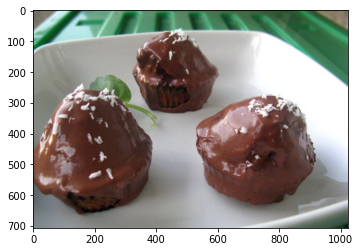

2021-12-08  11:02:06 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TRANSFORMED IMAGE


In [13]:
# Test if it works
original_image = train_dataset[1][0]
transformed_image = test_trans(original_image)
print(f"ORIGINAL IMAGE SHAPE: {np.array(original_image).shape}")
print(f"TRANSFORMED IMAGE SHAPE: {transformed_image.shape}")
print(transformed_image)

# Plot original image
print('ORIGINAL IMAGE')
plt.imshow(original_image)
plt.show()

# Plot transformed image
print('TRANSFORMED IMAGE')
plt.imshow(transformed_image.permute([1,2,0]))
plt.show()

### Train transformation pipeline

In [14]:
# Train transformation pipeline
scale = 300
train_trans = transforms.Compose([
        transforms.Resize(scale),  # This resize the image, but keep the proportion
        transforms.RandomRotation([-45, 45]),  # This apply a random rotation to the image
        transforms.RandomCrop(input_shape),  # This apply a random crop to the image, ensuring the proper shape
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        ])

ORIGINAL IMAGE SHAPE: (707, 1024, 3)
TRANSFORMED IMAGE SHAPE: torch.Size([3, 224, 224])
tensor([[[-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
         [-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
         [-2.1179, -2.1179, -2.1179,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [ 0.6221,  0.9646,  0.9646,  ...,  0.7762,  0.8276,  0.8104],
         [ 0.6221,  0.6392,  1.1529,  ...,  0.7419,  0.7762,  0.8447],
         [ 0.5536,  0.5536,  0.6221,  ...,  0.8276,  0.8276,  0.7419]],

        [[-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
         [-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
         [-2.0357, -2.0357, -2.0357,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [ 0.0651,  0.2402,  0.2402,  ...,  0.9580,  0.9755,  0.9755],
         [ 0.0301, -0.0049,  0.4503,  ...,  0.9230,  0.9405,  0.9755],
         [-0.0399, -0.0399,  0.0476,  ...,  0.9405,  0.9405,  0.9930]],

        [[-1.8044, -1.8044, 

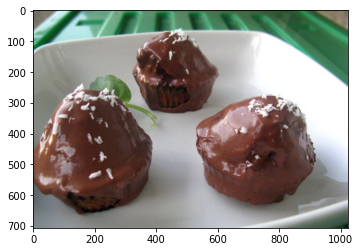

2021-12-08  11:02:06 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TRANSFORMED IMAGE


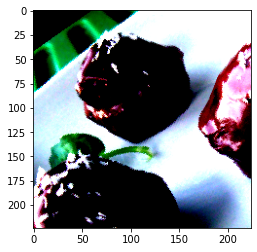

In [15]:
# Test if it works
original_image = train_dataset[1][0]
transformed_image = train_trans(original_image)
print(f"ORIGINAL IMAGE SHAPE: {np.array(original_image).shape}")
print(f"TRANSFORMED IMAGE SHAPE: {transformed_image.shape}")
print(transformed_image)

# Plot original image
print('ORIGINAL IMAGE')
plt.imshow(original_image)
plt.show()

# Plot transformed image
print('TRANSFORMED IMAGE')
plt.imshow(transformed_image.permute([1,2,0]))
plt.show()

Update the dataset with the proper transformation

In [16]:
# Redefine the datasets with the proper transform
train_dataset.transform = train_trans
val_dataset.transform   = test_trans
test_dataset.transform  = test_trans

### Create the dataloader

In this case we can consider to use multiple workers to load data concurrently. 

Since we are loading and decoding images from disk, this may be a bottleneck.

In [17]:
# Dataloader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True,  num_workers=8)
val_dataloader   = DataLoader(dataset=val_dataset,   batch_size=1,  shuffle=False, num_workers=8)
test_dataloader  = DataLoader(dataset=test_dataset,  batch_size=1,  shuffle=False, num_workers=8)

In [18]:
### Test if it works
# Train batch
image_batch, label_batch = next(iter(train_dataloader))
print(f"\nTrain input batch shape: {image_batch.shape}")
print(f"Train label batch shape: {label_batch.shape}")

# Validation batch
image_batch, label_batch = next(iter(val_dataloader))
print(f"\nValidation input batch shape: {image_batch.shape}")
print(f"Validation label batch shape: {label_batch.shape}")

# Test batch
image_batch, label_batch = next(iter(test_dataloader))
print(f"\nTest input batch shape: {image_batch.shape}")
print(f"Test label batch shape: {label_batch.shape}")


Train input batch shape: torch.Size([50, 3, 224, 224])
Train label batch shape: torch.Size([50])

Validation input batch shape: torch.Size([1, 3, 224, 335])
Validation label batch shape: torch.Size([1])

Test input batch shape: torch.Size([1, 3, 224, 224])
Test label batch shape: torch.Size([1])


# Network

## Import the pretrained network

Some of the most used architectures are available in the PyTorch [models](https://pytorch.org/vision/stable/models.html) library.

In this example we use the AlexNet architecture, presented in one of the most influential paper in the computer vision field (https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

PyTorch also provides (optionally) pretrained weights, clearly required for a transfer learning. The network has been trained to classify images among 1000 different categories, using data from the famous ImageNet dataset.

In [19]:
### Import the pretrained network
net = torchvision.models.alexnet(pretrained=True)
# Print the network architecture
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Analyze the pretrained network

### Accessing network layers

In [20]:
# Example: access a specific layer
print(net.features[6])

Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [21]:
# Example: access the weight of the third convolutional layer
print(net.features[6].weight)

Parameter containing:
tensor([[[[ 2.4858e-02,  1.3116e-02,  2.8198e-02],
          [ 4.2541e-02,  5.7339e-02, -6.0905e-03],
          [-4.1912e-03,  9.3096e-03, -1.5442e-02]],

         [[-3.8954e-03, -7.8586e-02, -5.1808e-02],
          [ 2.6484e-02, -4.9877e-02, -1.7763e-03],
          [ 8.2902e-03, -4.9339e-02,  3.1145e-02]],

         [[ 1.6455e-02, -1.2150e-02,  1.7428e-02],
          [ 5.2012e-02, -6.7141e-03,  2.7325e-02],
          [ 7.5568e-03, -4.2402e-02, -2.7909e-02]],

         ...,

         [[-1.7289e-04,  2.4099e-02,  3.6948e-02],
          [-2.4145e-02, -3.5276e-02,  3.6910e-03],
          [ 1.9541e-02, -3.0342e-02, -3.5262e-02]],

         [[ 1.3239e-02, -1.8624e-02, -5.3330e-02],
          [ 1.7639e-04, -1.4714e-02, -2.2829e-02],
          [-6.7702e-03,  2.3287e-02,  1.3873e-02]],

         [[ 3.0512e-02,  7.5860e-03,  4.9459e-04],
          [-4.5703e-03, -1.2827e-02, -6.5061e-03],
          [-9.8111e-03, -1.5570e-02,  1.9379e-02]]],


        [[[ 1.3660e-02, -3.9180

### Pretrained network output

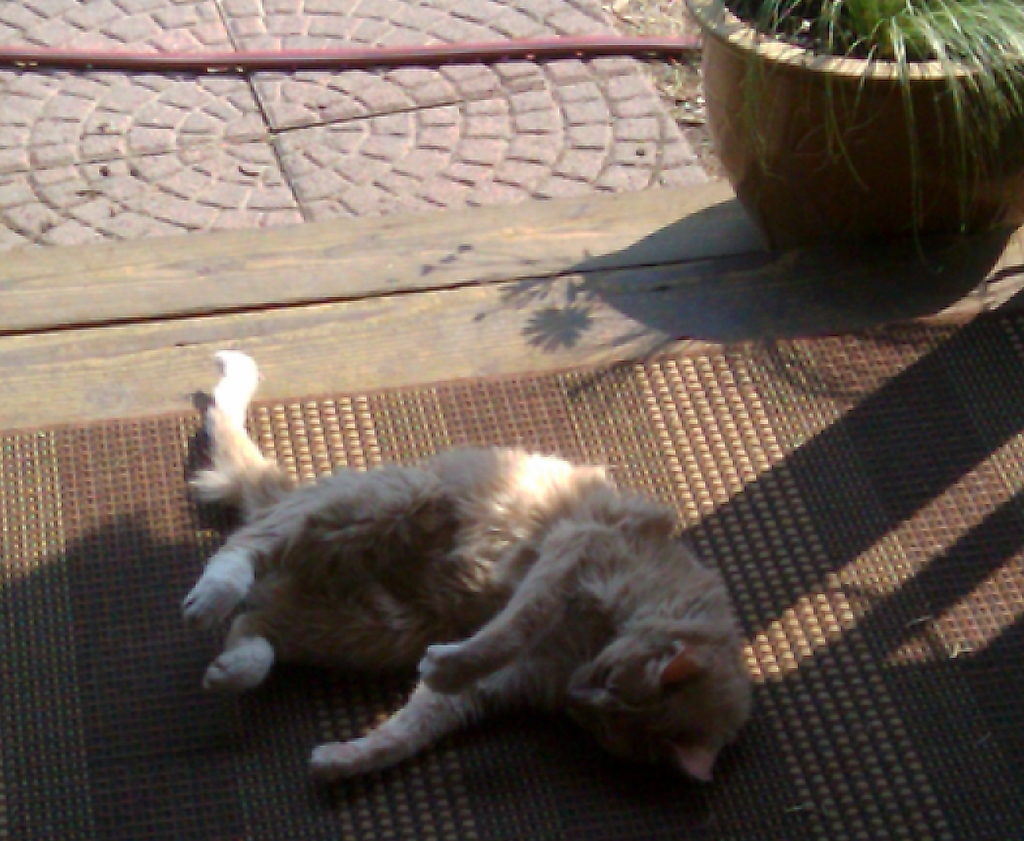

In [22]:
### Check the network output
# Get an image from our dataset
index = 2
sample_image, sample_label = val_dataset[index]
sample_image = sample_image.unsqueeze(0)

Image.open(val_dataset.samples[index][0])

In [23]:
# Evaluate the pretrained network output
net.eval()
with torch.no_grad(): # Disable gradient tracking
    out = net(sample_image)

print(f"INPUT SHAPE: {sample_image.shape}")
print(f"OUTPUT SHAPE: {out.shape}")

INPUT SHAPE: torch.Size([1, 3, 224, 272])
OUTPUT SHAPE: torch.Size([1, 1000])


In [24]:
#!pip install nbformat

In [25]:
# Plot directly the network output
fig = px.bar(y=out.flatten().cpu().numpy())
fig.update_layout(
    xaxis_title='Class Index',
    yaxis_title='Linear Network Output'
)

In [26]:
# Apply a softmax to the network output
softmax_out = torch.softmax(out, dim=1) #TODO
softmax_out = softmax_out.flatten().cpu().numpy()

fig = px.bar(y=softmax_out)
fig.update_layout(
    xaxis_title='Class Index',
    yaxis_title='Softmax Network Output'
)

In [27]:
### Check the 10 most probable classes

# Load human readable classes
with open('imagenet1000_clsid_to_human.txt', 'r') as f:
    dict_text = f.read()
    id_to_human = eval(dict_text)

pprint(id_to_human)

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon '
    'carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Amb

In [28]:
# Top 10 classes
top10_class_id = softmax_out.argsort()[::-1][:10] # Sort in descending order and take the first 10 elements
for idx in top10_class_id:
  print(f"{100 * softmax_out[idx]:.1f}% - Class: {id_to_human[idx]} (class index: {idx})")

7.8% - Class: Cardigan, Cardigan Welsh corgi (class index: 264)
7.5% - Class: lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (class index: 387)
3.3% - Class: beagle (class index: 162)
3.1% - Class: English setter (class index: 212)
3.0% - Class: tabby, tabby cat (class index: 281)
2.7% - Class: Madagascar cat, ring-tailed lemur, Lemur catta (class index: 383)
2.4% - Class: common iguana, iguana, Iguana iguana (class index: 39)
2.2% - Class: Shetland sheepdog, Shetland sheep dog, Shetland (class index: 230)
2.2% - Class: spindle (class index: 816)
2.2% - Class: polecat, fitch, foulmart, foumart, Mustela putorius (class index: 358)


# Transfer learning

In [29]:
# Print original network structure
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Disable the parameters update

In [30]:
# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in net.named_parameters():
    print(param_name)
    print('\tFreezing update')
    param.requires_grad = False  

features.0.weight
	Freezing update
features.0.bias
	Freezing update
features.3.weight
	Freezing update
features.3.bias
	Freezing update
features.6.weight
	Freezing update
features.6.bias
	Freezing update
features.8.weight
	Freezing update
features.8.bias
	Freezing update
features.10.weight
	Freezing update
features.10.bias
	Freezing update
classifier.1.weight
	Freezing update
classifier.1.bias
	Freezing update
classifier.4.weight
	Freezing update
classifier.4.bias
	Freezing update
classifier.6.weight
	Freezing update
classifier.6.bias
	Freezing update


### Modify the architecture

In [31]:
# Change the last layer to match the new reduced problem    
num_classes = 4
#probably too many parameters
net.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Enable the parameters update for specific layers

In [32]:
# Allow the training of the last two layers (classifier[4] and classifier[6])
for param in net.classifier[4].parameters():
    param.requires_grad = True 
for param in net.classifier[6].parameters():
    param.requires_grad = True 

In [33]:
# Check if correct
for param_name, param in net.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

features.0.weight 	- requires_grad=False
features.0.bias 	- requires_grad=False
features.3.weight 	- requires_grad=False
features.3.bias 	- requires_grad=False
features.6.weight 	- requires_grad=False
features.6.bias 	- requires_grad=False
features.8.weight 	- requires_grad=False
features.8.bias 	- requires_grad=False
features.10.weight 	- requires_grad=False
features.10.bias 	- requires_grad=False
classifier.1.weight 	- requires_grad=False
classifier.1.bias 	- requires_grad=False
classifier.4.weight 	- requires_grad=True
classifier.4.bias 	- requires_grad=True
classifier.6.weight 	- requires_grad=True
classifier.6.bias 	- requires_grad=True


# Training

## Loss and Optimizer

In [34]:
# Define a loss function (CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss()

# Define an optimizer
lr = 1e-3
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)

# Select the proper device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move all the network parameters to the selected device
net.to(device)
print(device)

cuda


## Training function

In [35]:
### Training function
def train_epoch(net, device, dataloader, loss_fn, optimizer):
    # Set train mode
    net.train()
    for image_batch, label_batch in dataloader:
        # Move tensors to the selected device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        # Forward pass
        out = net(image_batch)
        # Evaluate loss
        loss = loss_fn(out, label_batch)
        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        print('\t Training loss (single batch):', float(loss.data))

## Testing function

In [36]:
### Testing function
def test_epoch(net, device, dataloader, loss_fn):
    # Set evaluation mode
    net.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label_batch in tqdm(dataloader):
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Forward pass
            out = net(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(out)
            conc_label.append(label_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return conc_out, conc_label, val_loss.data # We return all the outputs, all the labels and the global loss

## Training loop (fine-tuning)

In [39]:
### Training cycle
print(f"training device = {device}")
num_epochs = 5 # 20
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    print(f"EPOCH {epoch + 1}/{num_epochs}")
    ### Training (use the training function)
    train_epoch(
        net=net,
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    ### Train loss (use the TESTING function! We want the train loss but using the network in eval mode and without random transformations)
    # NOTE: understand why we are doing this!
    _, _, train_loss = test_epoch(
        net=net,
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn)
    # Print Train loss
    print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
    train_losses.append(train_loss)

    ### Validation  (use the testing function)
    _, _, val_loss = test_epoch(
        net=net,
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    # Print Validation loss
    print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {val_loss}\n\n")
    val_losses.append(val_loss)

    ### Save model parameters
    torch.save(net.state_dict(), 'finetuned_model.pth')

training device = cuda
EPOCH 1/5
	 Training loss (single batch): 0.2057792842388153
	 Training loss (single batch): 0.1020563393831253
	 Training loss (single batch): 0.25792208313941956
	 Training loss (single batch): 0.0523143969476223
	 Training loss (single batch): 0.07187563180923462
	 Training loss (single batch): 0.1131543442606926
	 Training loss (single batch): 0.34371644258499146
	 Training loss (single batch): 0.33088138699531555
	 Training loss (single batch): 0.12822751700878143
	 Training loss (single batch): 0.043759655207395554
	 Training loss (single batch): 0.2698058485984802
	 Training loss (single batch): 0.3455347716808319
	 Training loss (single batch): 0.03243054449558258
	 Training loss (single batch): 0.1567741483449936
	 Training loss (single batch): 0.18031612038612366
	 Training loss (single batch): 0.27236220240592957
	 Training loss (single batch): 0.5340930223464966
	 Training loss (single batch): 0.44375553727149963
	 Training loss (single batch): 0.1612

100%|██████████| 35/35 [00:24<00:00,  1.45it/s]




	 TRAIN - EPOCH 1/5 - train loss: 0.08379500359296799




100%|██████████| 437/437 [00:07<00:00, 60.80it/s]




	 VALIDATION - EPOCH 1/5 - val loss: 0.2829076945781708


EPOCH 2/5
	 Training loss (single batch): 0.04942362383008003
	 Training loss (single batch): 0.36903080344200134
	 Training loss (single batch): 0.08632627129554749
	 Training loss (single batch): 0.13822025060653687
	 Training loss (single batch): 0.18420490622520447
	 Training loss (single batch): 0.12096891552209854
	 Training loss (single batch): 0.18633604049682617
	 Training loss (single batch): 0.34119927883148193
	 Training loss (single batch): 0.05595745891332626
	 Training loss (single batch): 0.015873465687036514
	 Training loss (single batch): 0.07888501137495041
	 Training loss (single batch): 0.12860044836997986
	 Training loss (single batch): 0.07447411864995956
	 Training loss (single batch): 0.10397039353847504
	 Training loss (single batch): 0.14777202904224396
	 Training loss (single batch): 0.027536330744624138
	 Training loss (single batch): 0.02972937375307083
	 Training loss (single batch): 0.1010984629

100%|██████████| 35/35 [00:22<00:00,  1.57it/s]




	 TRAIN - EPOCH 2/5 - train loss: 0.08905263245105743




100%|██████████| 437/437 [00:07<00:00, 60.12it/s]




	 VALIDATION - EPOCH 2/5 - val loss: 0.2617691159248352


EPOCH 3/5
	 Training loss (single batch): 0.0931677371263504
	 Training loss (single batch): 0.22586053609848022
	 Training loss (single batch): 0.18034997582435608
	 Training loss (single batch): 0.014299154281616211
	 Training loss (single batch): 0.09551786631345749
	 Training loss (single batch): 0.40656596422195435
	 Training loss (single batch): 0.22919036448001862
	 Training loss (single batch): 0.3292432129383087
	 Training loss (single batch): 0.07720207422971725
	 Training loss (single batch): 0.223430335521698
	 Training loss (single batch): 0.13437463343143463
	 Training loss (single batch): 0.1865025758743286
	 Training loss (single batch): 0.11006055027246475
	 Training loss (single batch): 0.19197243452072144
	 Training loss (single batch): 0.2002442181110382
	 Training loss (single batch): 0.19507911801338196
	 Training loss (single batch): 0.22494038939476013
	 Training loss (single batch): 0.0148554015904665


100%|██████████| 35/35 [00:23<00:00,  1.50it/s]




	 TRAIN - EPOCH 3/5 - train loss: 0.07489427924156189




100%|██████████| 437/437 [00:05<00:00, 73.87it/s]




	 VALIDATION - EPOCH 3/5 - val loss: 0.27082395553588867


EPOCH 4/5
	 Training loss (single batch): 0.23228943347930908
	 Training loss (single batch): 0.1588519662618637
	 Training loss (single batch): 0.020160865038633347
	 Training loss (single batch): 0.07115842401981354
	 Training loss (single batch): 0.1865035444498062
	 Training loss (single batch): 0.17297692596912384
	 Training loss (single batch): 0.07148658484220505
	 Training loss (single batch): 0.07167146354913712
	 Training loss (single batch): 0.20495730638504028
	 Training loss (single batch): 0.17567554116249084
	 Training loss (single batch): 0.18428830802440643
	 Training loss (single batch): 0.11576420813798904
	 Training loss (single batch): 0.06160619854927063
	 Training loss (single batch): 0.059218838810920715
	 Training loss (single batch): 0.26730090379714966
	 Training loss (single batch): 0.28284209966659546
	 Training loss (single batch): 0.1552366465330124
	 Training loss (single batch): 0.178965643048

100%|██████████| 35/35 [00:24<00:00,  1.44it/s]




	 TRAIN - EPOCH 4/5 - train loss: 0.07390851527452469




100%|██████████| 437/437 [00:06<00:00, 62.65it/s]




	 VALIDATION - EPOCH 4/5 - val loss: 0.31182605028152466


EPOCH 5/5
	 Training loss (single batch): 0.11086354404687881
	 Training loss (single batch): 0.14032259583473206
	 Training loss (single batch): 0.05635855719447136
	 Training loss (single batch): 0.14799097180366516
	 Training loss (single batch): 0.10374899953603745
	 Training loss (single batch): 0.1687362790107727
	 Training loss (single batch): 0.1294969916343689
	 Training loss (single batch): 0.025377407670021057
	 Training loss (single batch): 0.12948468327522278
	 Training loss (single batch): 0.052238088101148605
	 Training loss (single batch): 0.3055732846260071
	 Training loss (single batch): 0.08542633801698685
	 Training loss (single batch): 0.12151739001274109
	 Training loss (single batch): 0.15709269046783447
	 Training loss (single batch): 0.27502894401550293
	 Training loss (single batch): 0.07480691373348236
	 Training loss (single batch): 0.2278151512145996
	 Training loss (single batch): 0.1363187730312

100%|██████████| 35/35 [00:22<00:00,  1.52it/s]




	 TRAIN - EPOCH 5/5 - train loss: 0.056579381227493286




100%|██████████| 437/437 [00:07<00:00, 58.79it/s]




	 VALIDATION - EPOCH 5/5 - val loss: 0.2963106036186218




# Result analysis

In [40]:
# Load saved parameters
net.load_state_dict(torch.load('finetuned_model.pth'))

<All keys matched successfully>

## Final test

In [41]:
### Test loss
test_outputs, test_labels, test_loss = test_epoch(
    net=net,
    device=device, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn)
# Print Test loss
print(f"\n\nTEST LOSS : {test_loss}")

100%|██████████| 546/546 [00:09<00:00, 57.36it/s]



TEST LOSS : 0.1974317878484726


## Confusion matrix

In [42]:
### Confusion matrix
# Predicted labels
y_true = test_labels.cpu().data.numpy()
y_pred = test_outputs.cpu().argmax(dim=1).numpy()
# Evaluate confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
# Show the confusion matrix
pd.DataFrame(cm)

0   1    2    3
0  140   0    3    0
1    2  68    1    7
2    7   1  187    5
3    1   4    3  117

## Analyze network weights

In [43]:
# Print network architecture
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

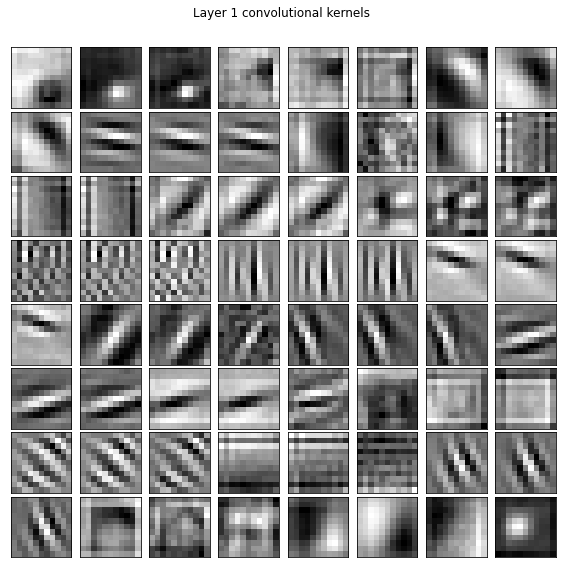

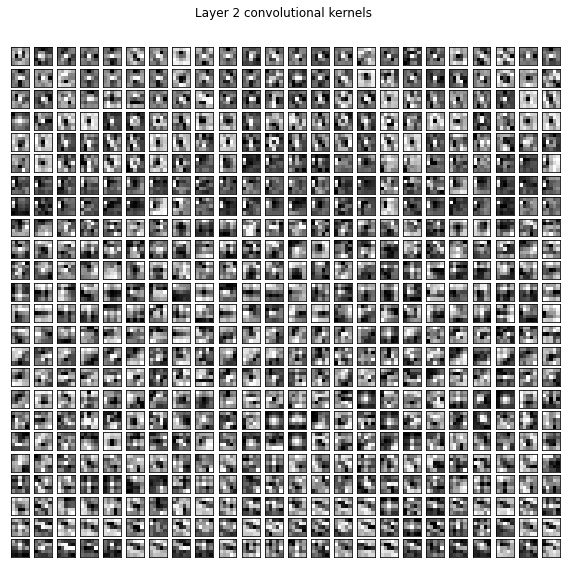

In [44]:
### Extract weights 
# Layer 1 weights
weights_l1 = net.features[0].weight.data.cpu().numpy()
# Layer 2 weights
weights_l2 = net.features[3].weight.data.cpu().numpy()

### Plot the weights (this is a utility function, no need to analyze this code)
def plot_nchw_data(data, h_num, v_num, title):
    fig, axs = plt.subplots(h_num, v_num, figsize=(8,8))
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()

plot_nchw_data(weights_l1, 8, 8, 'Layer 1 convolutional kernels')
plot_nchw_data(weights_l2, 24, 24, 'Layer 2 convolutional kernels')


## Analyze activations

Register the forward hooks

In [45]:
# Hook function to call during forward pass
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(net.features[1].register_forward_hook(hook_fn))
hook_handles.append(net.features[4].register_forward_hook(hook_fn))
hook_handles.append(net.features[7].register_forward_hook(hook_fn))
hook_handles.append(net.features[9].register_forward_hook(hook_fn))
hook_handles.append(net.features[11].register_forward_hook(hook_fn))

Analyze the activations for a single input image

In [46]:
# Define input
net_input = test_dataset[1][0].unsqueeze(0)
net_input = net_input.to(device)

# Show original image
Image.open(test_dataset.samples[1][0])

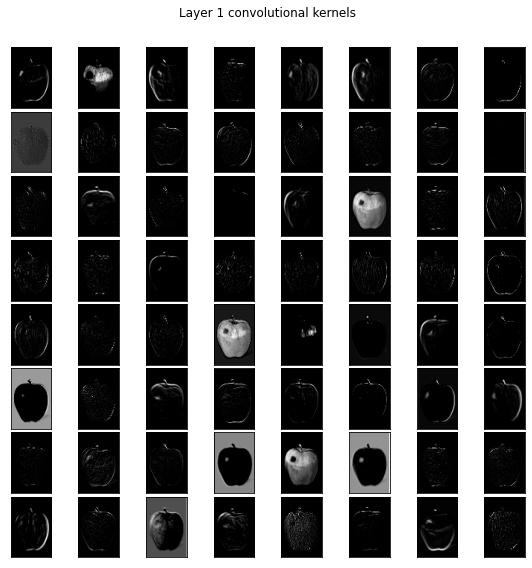

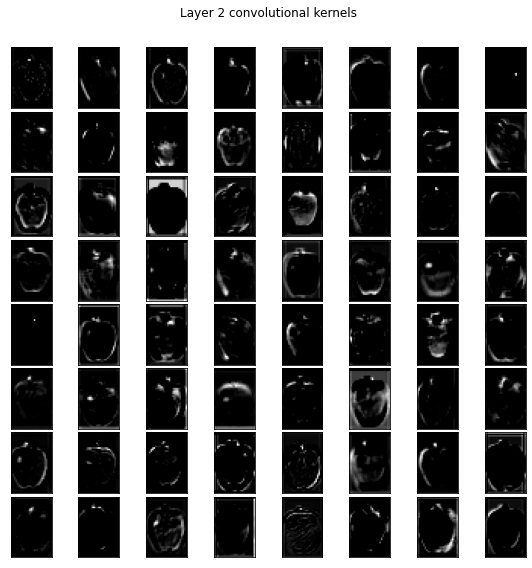

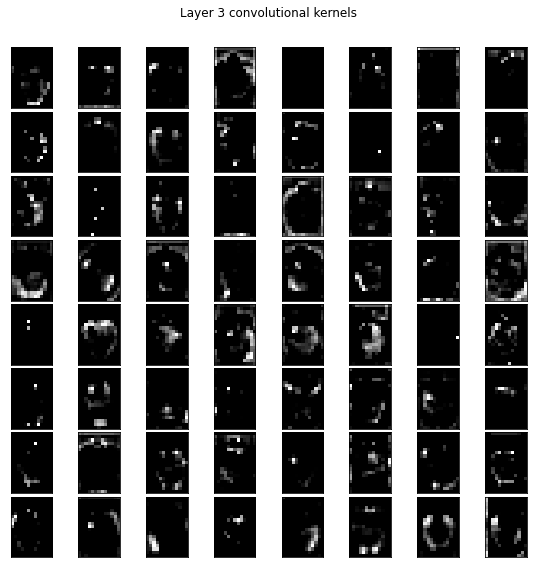

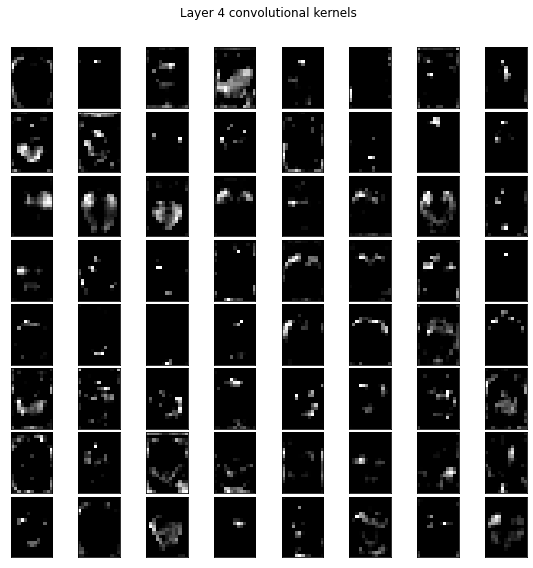

In [47]:
# Evaluate output
net.eval()
with torch.no_grad():
    intermediate_outputs = []
    out = net(net_input)
    # Now the intermediate_outputs list contains the intermediate outputs thanks to the hook function

# Analyze intermediate outputs
for layer_num, intermediate_output in enumerate(intermediate_outputs):
    intermediate_output = intermediate_output.cpu().data.numpy()
    # Plot
    plot_nchw_data(intermediate_output, 8, 8, 'Layer %d convolutional kernels' % (layer_num + 1))

Remove the registered forward hooks

In [48]:
# Remove the hooks using the handles saved during the hooks definition
for handle in hook_handles:
  handle.remove()

## Bidimensional space visualization

Here we want to analyze the output of second last layer of the network (4096 different neurons in this architecture). This is typically considered the *feature space*, since the last layer uses the information stored in these variables to perform the final classification.

A good feature space contains samples of different classes well spearated each other, and samples of the same class clustered together.

Since we cannot visualize such a high dimensional space, we need dimensionality reduction techniques to have an idea about this condition.

In [49]:
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

First, we need another forward hook to register the output of the second last layer.

In [50]:
# Hook function to call during forward pass (extract second last layer features)
def hook_feature_space(module, input, output):
    feature_space.append(output) # feature_space must be a list defined before evaluating the network output

# Attach the hook function to layer classifier[5]
hook_handle = net.classifier[5].register_forward_hook(hook_feature_space)

Since we now have the hook registered, when we evaluate the test outputs the `feature_space` list will be updated with the feature space values corresponding to the test samples.

In [51]:
feature_space = [] # This list will be filled by the feature space values

### Analyze all the test samples
test_outputs, test_labels, test_loss = test_epoch(
    net=net,
    device=device, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn)

# Concatenate all the features in a single tensor
feature_space = torch.cat(feature_space)

100%|██████████| 546/546 [00:06<00:00, 79.60it/s]


Let's verify if the list has been populated.

In [52]:
print(feature_space.shape)

torch.Size([546, 4096])


Since the following analyses won't use PyTorch, let's move everything back to CPU.

In [53]:
feature_space = feature_space.cpu()
test_labels   = test_labels.cpu()
test_outputs  = test_outputs.cpu()

### t-distributed Stochastic Neighbor Embedding

t-SNE [[ref]](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In [54]:
### t-SNE embedding of the dataset (t-distributed Stochastic Neighbor Embedding)
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
feature_space_tsne = tsne.fit_transform(feature_space)

Computing t-SNE embedding


In [55]:
print(f"FEATURE SPACE SHAPE: {feature_space.shape}")
print(f"FEATURE SPACE SHAPE (TSNE): {feature_space_tsne.shape}")

FEATURE SPACE SHAPE: torch.Size([546, 4096])
FEATURE SPACE SHAPE (TSNE): (546, 2)


Let's prepare a pandas dataframe just for plotting (no need to analyze this code)

In [56]:
# Prepare dataframe for plotting (no need to analyze this code)
df = pd.DataFrame(feature_space_tsne)
df['label'] = test_labels
df['label_name'] = df.label.apply(lambda l: id_to_label[l])
df

0          1  label label_name
0    50.062412   1.824309      3     muffin
1    25.299149  37.472347      1      apple
2    22.641682  -7.230625      0   aircraft
3    15.067679 -28.675501      2        cat
4    28.676514  -3.172755      3     muffin
..         ...        ...    ...        ...
541  22.256777  31.638908      1      apple
542 -51.322735   4.930806      0   aircraft
543 -47.498909  -0.742729      0   aircraft
544   2.514024 -49.245602      2        cat
545   6.851380 -44.737003      2        cat

[546 rows x 4 columns]

In [57]:
### Plot
px.scatter(df, x=0, y=1, color='label_name', hover_data=[df.index])

We can check what are the samples that falls in the wrong cluster to see if the error may be considered "reasonable" or the network is completely wrong.

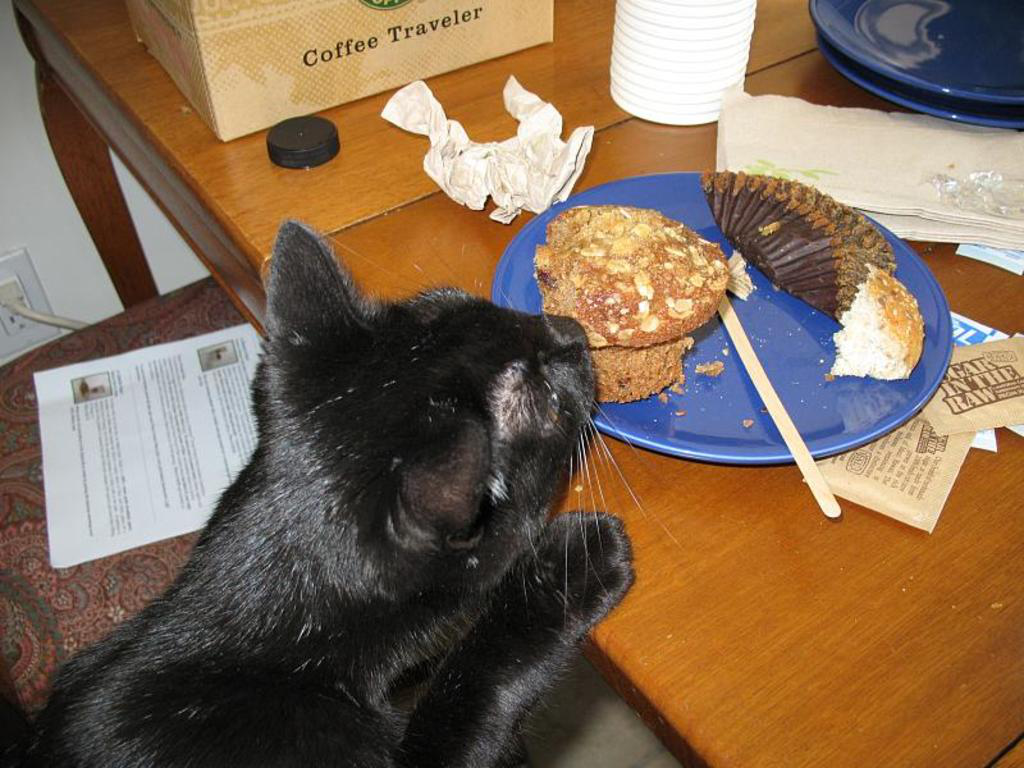

In [58]:
Image.open(test_dataset.samples[122][0])

### Isomap embedding

We can do the same thing with different type of dimensionality reduction methods, such as [Isometric Mapping Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html) (distance-preserving embedding).

In [59]:
### Isomap embedding of the dataset
print("Computing Isomap")
isomap = manifold.Isomap(n_components=2)
feature_space_isomap = isomap.fit_transform(feature_space)

Computing Isomap


In [60]:
print(f"FEATURE SPACE SHAPE: {feature_space.shape}")
print(f"FEATURE SPACE SHAPE (Isomap): {feature_space_isomap.shape}")

FEATURE SPACE SHAPE: torch.Size([546, 4096])
FEATURE SPACE SHAPE (Isomap): (546, 2)


In [61]:
# Prepare dataframe for plotting (no need to analyze this code)
df = pd.DataFrame(feature_space_isomap)
df['label'] = test_labels
df['label_name'] = df.label.apply(lambda l: id_to_label[l])

In [62]:
### Plot
px.scatter(df, x=0, y=1, color='label_name', hover_data=[df.index])

## Excercises:


*   What if we don't use pre-trained weights? Try changing the dataset size to understand the powerful effects of pre-training (fewer samples needed to converge to high accuracy on a new domain).
*   Try even more complex (and recent) network architectures, such as ResNet-101 from [models](https://pytorch.org/vision/stable/models.html)

